In [1]:
import sys
sys.path.append('../src')

import warnings
# Global suppression
warnings.filterwarnings("ignore", message="Parsing dates in .* when dayfirst=True was specified")
warnings.filterwarnings("ignore", category=FutureWarning)

from preprocessing import *
import tame
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm import tqdm
from config import CONFIG

import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Dataset, DataLoader, Subset, random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def _cuda(obj):
    if isinstance(obj, torch.nn.Module):
        return obj.cuda()
    elif isinstance(obj, torch.Tensor):
        return obj.cuda()
    elif isinstance(obj, np.ndarray):
        return torch.from_numpy(obj).cuda()
    
def index_value(data):
    index = data // (CONFIG['split_num'] + 1)
    value = data % (CONFIG['split_num'] + 1)
    index = Variable(_cuda(index))
    value = Variable(_cuda(value))
    return [index, value]

In [9]:
dfs = get_dfs()
biopsy_df = dfs['biopsy'].copy()
static_df= create_static_df(dfs)
vital_df = create_vitals_df(dfs, static_df)
med_df = create_medication_df(dfs, static_df)
lab_df = create_lab_values_df(dfs, static_df)
ts_data = create_ts_df(vital_df, lab_df, med_df, merge_lab=True, merge_med=True)
print(ts_data.columns)

full_dataset = NephroDataset(static_df, ts_data, biopsy_df, phase='test')
#datapoint_limit = 1000
#dataset = Subset(full_dataset, range(datapoint_limit))
batch_size = 32
data_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)
static_scaler = full_dataset.scaler
cat_scaler = full_dataset.label_encoders
categorical_cardinalities = full_dataset.categorical_cardinalities
print(f"Categorical cardinalities: {categorical_cardinalities}")

max rel_days 8034
max number of rows across all patients 1105
Index(['patient_id', 'transplant_id', 'rel_days', 'bp_sys', 'bp_dia', 'weight',
       'urine_volume', 'heart_rate', 'temperature', 'diuresis_time', 'albumin',
       'crphp', 'creatinine', 'leukocyte', 'proteinuria', 'L04AA06', 'L04AD01',
       'L04AD02'],
      dtype='object')
Categorical cardinalities: [438, 9, 3, 3, 9, 10, 2, 3]


In [ ]:
checkpoint = torch.load('../model_checkpoints/models/best.ckpt', weights_only=False)
print(checkpoint.keys())
print(checkpoint['epoch'])

model = tame.AutoEncoder(categorical_cardinalities=categorical_cardinalities)
#Load weights
model.load_state_dict(checkpoint['state_dict'])
model = model.to(device)

dict_keys(['epoch', 'best_metric', 'state_dict', 'best r2s'])
33


In [11]:
# load feature_mm file
with open('../feature_mm.json', 'r') as f:
    feature_mm = json.load(f)

print(list(feature_mm.keys()))

# load feature_ms file
with open('../feature_ms.json', 'r') as f:
    feature_ms = json.load(f)
print(list(feature_ms.keys()))

['bp_sys', 'bp_dia', 'weight', 'urine_volume', 'heart_rate', 'temperature', 'diuresis_time', 'albumin', 'crphp', 'creatinine', 'leukocyte', 'proteinuria', 'L04AA06', 'L04AD01', 'L04AD02']
['bp_sys', 'bp_dia', 'weight', 'urine_volume', 'heart_rate', 'temperature', 'diuresis_time', 'albumin', 'crphp', 'creatinine', 'leukocyte', 'proteinuria', 'L04AA06', 'L04AD01', 'L04AD02']


In [12]:
# After loading feature_mm
keys = list(feature_mm.keys())  # careful: assumes insertion order matches model

mins = torch.tensor([feature_mm[keys[i]][0] for i in range(15)], device=device)
maxs = torch.tensor([feature_mm[keys[i]][1] for i in range(15)], device=device)

means = torch.tensor([feature_ms[keys[i]][0] for i in range(15)], device=device)
stds = torch.tensor([feature_ms[keys[i]][1] for i in range(15)], device=device)

In [ ]:
def extract_features_and_labels(model, data_loader, mins, maxs, means, stds):
    model.eval()

    all_ts_features = []
    all_num_features = []
    all_cat_features = []
    all_pids = []
    cat_np = []
    num_np = []

    death_labels = []
    graft_loss_labels = []

    graft_loss_days = []
    mort_days = []
    rej_days = []

    with torch.no_grad():
        for batch in tqdm(data_loader):
            # Move inputs to GPU if needed
            ts_data = index_value(batch['input_ts_features'])
            neib = [index_value(batch['pre_input']), Variable(_cuda(batch['pre_time'])), index_value(batch['post_input']), Variable(_cuda(batch['post_time']))]

            static_num = Variable(_cuda(batch['static_numerical_features']))
            static_num_features = static_scaler.inverse_transform(static_num.cpu().numpy())
            all_num_features.append(static_num_features)

            num_np.append(static_num.cpu().numpy())

            static_cat = Variable(_cuda(batch['static_categorical_features']))
            static_cat_np = static_cat.cpu().numpy()  # Convert to numpy for easier processing
            cat_np.append(static_cat_np)
            cat_decodec = []
            for i, (col, le) in enumerate(cat_scaler.items()):
                cat_decodec.append(le.inverse_transform(static_cat_np[:, i]))
            cat_decoed = np.array(cat_decodec).T.tolist()
            all_cat_features.extend(cat_decoed)

            patient_ids = batch['patient_id']
            real_data = Variable(_cuda(batch['real_ts_data']))

            pad_mask = Variable(_cuda(batch['mask']))

            seq_lens = batch['seq_len']

            # De-normalize
            output = model(ts_data, neib, static_num, static_cat, mask=pad_mask)
            output_real = output * (maxs - mins)[None, None, :] + mins[None, None, :]

            loss_days = batch['loss_rel_days']
            death_days = batch['death_rel_days']
            rej_days_batch= batch['rej_rel_days_list']

            batch_size = real_data.size(0)

            for i in range(batch_size):
                valid_len = seq_lens[i]

                # limit seq len to 200
                if valid_len >= 200:
                    valid_len = 200
                    
                # Extract the valid part (not padded) for this patient
                real_slice = real_data[i, :valid_len, :]      # Shape: (valid_len, 1 + feature_dim)
                output_slice = output_real[i, :valid_len, :]  # Shape: (valid_len, feature_dim)

                # Separate rel_days and real features
                rel_days = real_slice[:, 0].unsqueeze(-1)     # Shape: (valid_len, 1)
                real_features = real_slice[:, 1:]             # Shape: (valid_len, feature_dim)

                # Replace NaNs in real features with output prediction
                nan_mask = torch.isnan(real_features)
                real_features[nan_mask] = output_slice[nan_mask]

                # z-score normalization
                real_features = (real_features - means) / stds

                all_ts_features.append(real_features.cpu().numpy())

    
                if torch.isnan(real_features).any():
                    print("NaN values found after fixing.")
                else:
                    print("No NaN values after fixing.")

                rej_days_i = rej_days_batch[i]
                if rej_days_i is None or len(rej_days_i) == 0:
                    rej_days_i = rel_days[-1]  # Use the last rel_day if no rejection days are available
                rej_days.append(rej_days_i)

                loss_day = loss_days[i].item()
                if loss_day is None or np.isnan(loss_day):
                    loss_day = rel_days[-1].cpu().item()

                if death_days[i].item() is None or np.isnan(death_days[i].item()):
                    death_day = rel_days[-1].cpu().item()
                else:
                    death_day = death_days[i].item()

                graft_loss_days.append(loss_day)
                mort_days.append(death_day)

            graft_loss_label = batch['graft_loss_label'].cpu().numpy()
            death_label = batch['death_label'].cpu().numpy()
            graft_loss_labels.append(graft_loss_label)
            death_labels.append(death_label)
            all_pids.append(patient_ids)

        #all_ts_features = np.array(all_ts_features)
        all_num_features = np.concatenate(all_num_features, axis=0)
        all_cat_features = np.array(all_cat_features)

        cat_np = np.array(np.concatenate(cat_np, axis=0))
        num_np = np.array(np.concatenate(num_np, axis=0))

        static_vectors = np.concatenate((cat_np, num_np), axis=1)

        graft_loss_labels = np.concatenate(graft_loss_labels, axis=0).squeeze()
        death_labels = np.concatenate(death_labels, axis=0).squeeze()

        all_pids = np.concatenate(all_pids, axis=0)
        #graft_loss_days = np.concatenate(graft_loss_days, axis=0)
        #mort_days = np.concatenate(mort_days, axis=0)
        #rej_days = np.concatenate([np.ravel(r) for r in rej_days], axis=0)
            
        return (
            all_ts_features, 
            all_num_features, 
            all_cat_features,
            static_vectors,
            all_pids, 
            death_labels, 
            graft_loss_labels, 
            graft_loss_days, 
            mort_days, 
            rej_days
        )

In [29]:
all_ts_features, all_num_features, all_cat_features, static_vectors, all_pids, death_labels, graft_loss_labels, \
    graft_loss_days, mort_days, rej_days = extract_features_and_labels(model, data_loader, mins, maxs, means, stds)

  2%|▏         | 2/97 [00:14<09:31,  6.02s/it]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

  3%|▎         | 3/97 [00:15<05:47,  3.70s/it]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.


  4%|▍         | 4/97 [00:15<03:34,  2.31s/it]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.


  6%|▌         | 6/97 [00:18<02:29,  1.64s/it]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

  8%|▊         | 8/97 [00:19<01:25,  1.04it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 10%|█         | 10/97 [00:22<01:36,  1.11s/it]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 12%|█▏        | 12/97 [00:25<01:48,  1.28s/it]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 14%|█▍        | 14/97 [00:27<01:27,  1.05s/it]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 16%|█▋        | 16/97 [00:28<00:58,  1.39it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 19%|█▊        | 18/97 [00:31<01:13,  1.07it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 21%|██        | 20/97 [00:31<00:41,  1.85it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 23%|██▎       | 22/97 [00:33<00:56,  1.32it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 25%|██▍       | 24/97 [00:34<00:37,  1.93it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 27%|██▋       | 26/97 [00:36<00:57,  1.24it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 29%|██▉       | 28/97 [00:37<00:32,  2.09it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 31%|███       | 30/97 [00:39<00:52,  1.29it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 33%|███▎      | 32/97 [00:40<00:30,  2.13it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 35%|███▌      | 34/97 [00:42<00:39,  1.59it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 37%|███▋      | 36/97 [00:42<00:23,  2.56it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 39%|███▉      | 38/97 [00:45<00:45,  1.29it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 41%|████      | 40/97 [00:45<00:26,  2.16it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 43%|████▎     | 42/97 [00:47<00:32,  1.70it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 45%|████▌     | 44/97 [00:47<00:19,  2.71it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 46%|████▋     | 45/97 [00:48<00:31,  1.64it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.


 48%|████▊     | 47/97 [00:49<00:27,  1.82it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 49%|████▉     | 48/97 [00:49<00:21,  2.32it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.


 52%|█████▏    | 50/97 [00:52<00:42,  1.11it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 54%|█████▎    | 52/97 [00:53<00:23,  1.90it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 56%|█████▌    | 54/97 [00:57<00:50,  1.18s/it]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 58%|█████▊    | 56/97 [00:57<00:27,  1.51it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 60%|█████▉    | 58/97 [01:01<00:39,  1.01s/it]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 62%|██████▏   | 60/97 [01:01<00:21,  1.73it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 64%|██████▍   | 62/97 [01:04<00:33,  1.05it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 66%|██████▌   | 64/97 [01:04<00:18,  1.81it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 68%|██████▊   | 66/97 [01:07<00:26,  1.17it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 70%|███████   | 68/97 [01:07<00:14,  1.98it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 72%|███████▏  | 70/97 [01:09<00:18,  1.48it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 74%|███████▍  | 72/97 [01:10<00:10,  2.41it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 76%|███████▋  | 74/97 [01:13<00:21,  1.08it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 78%|███████▊  | 76/97 [01:13<00:11,  1.85it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 80%|████████  | 78/97 [01:18<00:23,  1.25s/it]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 82%|████████▏ | 80/97 [01:18<00:11,  1.43it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 85%|████████▍ | 82/97 [01:21<00:13,  1.14it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 87%|████████▋ | 84/97 [01:21<00:06,  1.94it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 89%|████████▊ | 86/97 [01:24<00:08,  1.27it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 91%|█████████ | 88/97 [01:24<00:04,  2.12it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 92%|█████████▏| 89/97 [01:26<00:06,  1.15it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.


 94%|█████████▍| 91/97 [01:27<00:03,  1.55it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 95%|█████████▍| 92/97 [01:27<00:02,  2.00it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.


 97%|█████████▋| 94/97 [01:28<00:01,  1.79it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

 99%|█████████▉| 96/97 [01:29<00:00,  2.82it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN v

100%|██████████| 97/97 [01:29<00:00,  2.20it/s]

✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.
✅ No NaN values after fixing.


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


In [2]:
# read files from results directory
import os
import numpy as np
results_dir = '../dist_results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
dist_matrix = np.load(os.path.join(results_dir, 'emb_dist_matrix.npy'))
patient_ids = np.load(os.path.join(results_dir, 'emb_patient_ids.npy'), allow_pickle=True)

Distance matrix min: 0.0, max: 0.33487676460052207


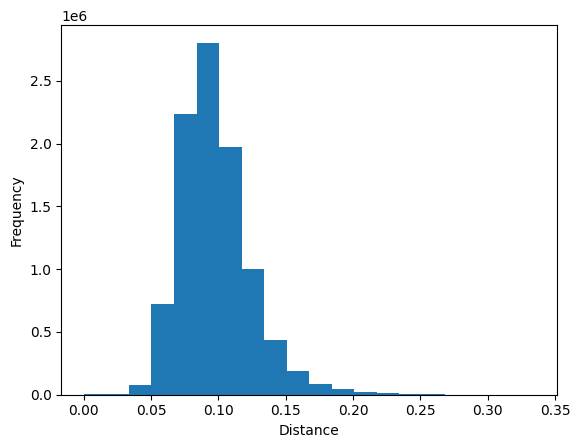

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Assume dist_matrix is a square 2D numpy array (distance matrix)
dist_min = np.min(dist_matrix)
dist_max = np.max(dist_matrix)

print(f"Distance matrix min: {dist_min}, max: {dist_max}")

plt.hist(dist_matrix.flatten(), bins=20)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# read files from results directory
import os
import numpy as np
results_dir = '../dist_results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
dist_matrix = np.load(os.path.join(results_dir, 'dist_matrix.npy'))
patient_ids = np.load(os.path.join(results_dir, 'patient_ids.npy'), allow_pickle=True)

Distance matrix min: 0.0, max: 2.0666949779956374


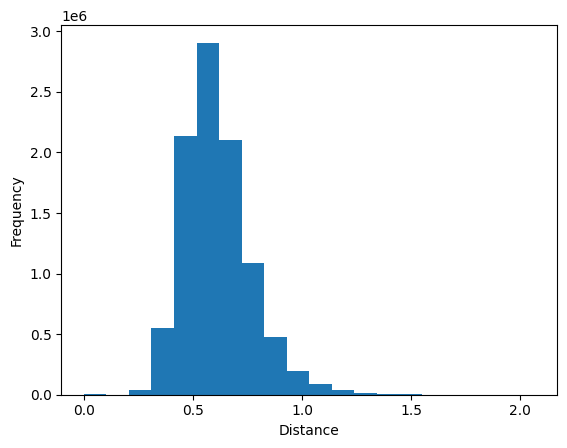

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Assume dist_matrix is a square 2D numpy array (distance matrix)
dist_min = np.min(dist_matrix)
dist_max = np.max(dist_matrix)

print(f"Distance matrix min: {dist_min}, max: {dist_max}")

plt.hist(dist_matrix.flatten(), bins=20)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()


In [4]:
import random
from wkmeans import wkmeans_epoch
def wkmeans(n_cluster, patient_ids, dist_matrix):
    assert len(dist_matrix) == len(patient_ids)
    assert dist_matrix.shape[0] == dist_matrix.shape[1]
    n_samples = len(patient_ids)  # ← FIXED LINE
    
    indices = list(range(n_samples))
    random.shuffle(indices)

    groups = [[idx] for idx in indices[:n_cluster]]
    for idx in indices[n_cluster:]:
        groups[random.randint(0, n_cluster - 1)].append(idx)

    for epoch in range(100):
        groups = wkmeans_epoch(dist_matrix, groups)
        for g in groups:
            for idx in g:
                if not isinstance(idx, (int, np.integer)) or idx < 0 or idx >= len(patient_ids):
                    raise ValueError(f"Invalid index {idx} in groups at epoch {epoch}")
        print(f"Epoch {epoch:02d}: {[len(g) for g in groups]}")

    cluster_results = []
    for g in groups:
        cluster_results.append([patient_ids[i] for i in g if i < len(patient_ids)])

    return cluster_results, groups

Epoch 00: [1722, 1381]
Epoch 01: [1566, 1537]
Epoch 02: [1514, 1589]
Epoch 03: [1501, 1602]
Epoch 04: [1500, 1603]
Epoch 05: [1504, 1599]
Epoch 06: [1505, 1598]
Epoch 07: [1506, 1597]
Epoch 08: [1506, 1597]
Epoch 09: [1506, 1597]
Epoch 10: [1506, 1597]
Epoch 11: [1506, 1597]
Epoch 12: [1506, 1597]
Epoch 13: [1506, 1597]
Epoch 14: [1506, 1597]
Epoch 15: [1506, 1597]
Epoch 16: [1506, 1597]
Epoch 17: [1506, 1597]
Epoch 18: [1506, 1597]
Epoch 19: [1506, 1597]
Epoch 20: [1506, 1597]
Epoch 21: [1506, 1597]
Epoch 22: [1506, 1597]
Epoch 23: [1506, 1597]
Epoch 24: [1506, 1597]
Epoch 25: [1506, 1597]
Epoch 26: [1506, 1597]
Epoch 27: [1506, 1597]
Epoch 28: [1506, 1597]
Epoch 29: [1506, 1597]
Epoch 30: [1506, 1597]
Epoch 31: [1506, 1597]
Epoch 32: [1506, 1597]
Epoch 33: [1506, 1597]
Epoch 34: [1506, 1597]
Epoch 35: [1506, 1597]
Epoch 36: [1506, 1597]
Epoch 37: [1506, 1597]
Epoch 38: [1506, 1597]
Epoch 39: [1506, 1597]
Epoch 40: [1506, 1597]
Epoch 41: [1506, 1597]
Epoch 42: [1506, 1597]
Epoch 43: [

c:\Files\02- Education\Master\Thesis\Code\tame-v2\notebooks\../src\wkmeans.py:10: RuntimeWarning: Mean of empty slice.
  dist_avg = dist_g.mean(0)


Epoch 03: [0, 3103, 0, 0, 0, 0]
Epoch 04: [3103, 0, 0, 0, 0, 0]
Epoch 05: [0, 3103, 0, 0, 0, 0]
Epoch 06: [3103, 0, 0, 0, 0, 0]
Epoch 07: [0, 3103, 0, 0, 0, 0]
Epoch 08: [3103, 0, 0, 0, 0, 0]
Epoch 09: [0, 3103, 0, 0, 0, 0]
Epoch 10: [3103, 0, 0, 0, 0, 0]
Epoch 11: [0, 3103, 0, 0, 0, 0]
Epoch 12: [3103, 0, 0, 0, 0, 0]
Epoch 13: [0, 3103, 0, 0, 0, 0]
Epoch 14: [3103, 0, 0, 0, 0, 0]
Epoch 15: [0, 3103, 0, 0, 0, 0]
Epoch 16: [3103, 0, 0, 0, 0, 0]
Epoch 17: [0, 3103, 0, 0, 0, 0]
Epoch 18: [3103, 0, 0, 0, 0, 0]
Epoch 19: [0, 3103, 0, 0, 0, 0]
Epoch 20: [3103, 0, 0, 0, 0, 0]
Epoch 21: [0, 3103, 0, 0, 0, 0]
Epoch 22: [3103, 0, 0, 0, 0, 0]
Epoch 23: [0, 3103, 0, 0, 0, 0]
Epoch 24: [3103, 0, 0, 0, 0, 0]
Epoch 25: [0, 3103, 0, 0, 0, 0]
Epoch 26: [3103, 0, 0, 0, 0, 0]
Epoch 27: [0, 3103, 0, 0, 0, 0]
Epoch 28: [3103, 0, 0, 0, 0, 0]
Epoch 29: [0, 3103, 0, 0, 0, 0]
Epoch 30: [3103, 0, 0, 0, 0, 0]
Epoch 31: [0, 3103, 0, 0, 0, 0]
Epoch 32: [3103, 0, 0, 0, 0, 0]
Epoch 33: [0, 3103, 0, 0, 0, 0]
Epoch 34

c:\Files\02- Education\Master\Thesis\Code\tame-v2\notebooks\../src\wkmeans.py:10: RuntimeWarning: Mean of empty slice.
  dist_avg = dist_g.mean(0)


Epoch 03: [0, 3103, 0, 0, 0, 0, 0, 0]
Epoch 04: [3103, 0, 0, 0, 0, 0, 0, 0]
Epoch 05: [0, 3103, 0, 0, 0, 0, 0, 0]
Epoch 06: [3103, 0, 0, 0, 0, 0, 0, 0]
Epoch 07: [0, 3103, 0, 0, 0, 0, 0, 0]
Epoch 08: [3103, 0, 0, 0, 0, 0, 0, 0]
Epoch 09: [0, 3103, 0, 0, 0, 0, 0, 0]
Epoch 10: [3103, 0, 0, 0, 0, 0, 0, 0]
Epoch 11: [0, 3103, 0, 0, 0, 0, 0, 0]
Epoch 12: [3103, 0, 0, 0, 0, 0, 0, 0]
Epoch 13: [0, 3103, 0, 0, 0, 0, 0, 0]
Epoch 14: [3103, 0, 0, 0, 0, 0, 0, 0]
Epoch 15: [0, 3103, 0, 0, 0, 0, 0, 0]
Epoch 16: [3103, 0, 0, 0, 0, 0, 0, 0]
Epoch 17: [0, 3103, 0, 0, 0, 0, 0, 0]
Epoch 18: [3103, 0, 0, 0, 0, 0, 0, 0]
Epoch 19: [0, 3103, 0, 0, 0, 0, 0, 0]
Epoch 20: [3103, 0, 0, 0, 0, 0, 0, 0]
Epoch 21: [0, 3103, 0, 0, 0, 0, 0, 0]
Epoch 22: [3103, 0, 0, 0, 0, 0, 0, 0]
Epoch 23: [0, 3103, 0, 0, 0, 0, 0, 0]
Epoch 24: [3103, 0, 0, 0, 0, 0, 0, 0]
Epoch 25: [0, 3103, 0, 0, 0, 0, 0, 0]
Epoch 26: [3103, 0, 0, 0, 0, 0, 0, 0]
Epoch 27: [0, 3103, 0, 0, 0, 0, 0, 0]
Epoch 28: [3103, 0, 0, 0, 0, 0, 0, 0]
Epoch 29: [0

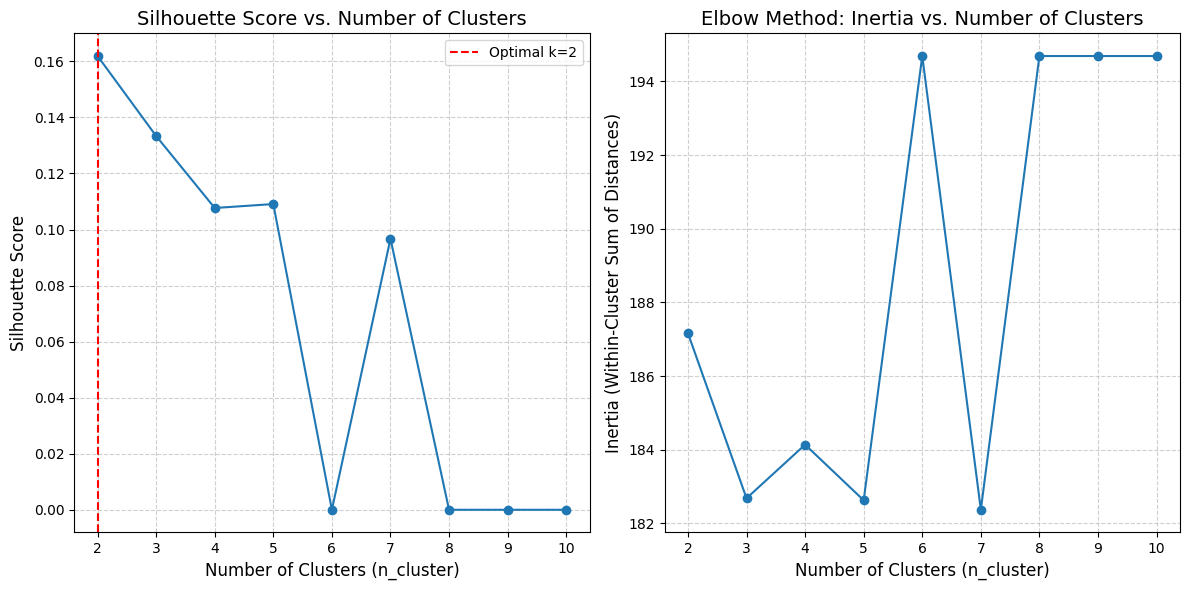

In [ ]:
# exploring for best n_clusters
from sklearn.metrics import silhouette_score

def compute_inertia(dist_matrix, groups):
    inertia = 0.0
    for group in groups:
        if len(group) == 0:
            continue
        distances = dist_matrix[np.ix_(group, group)]
        # Use np.sum with axis=1 for summing rows
        medoid_idx_in_group = np.argmin(np.sum(distances, axis=1))
        medoid_idx = group[medoid_idx_in_group]
        for idx in group:
            inertia += dist_matrix[idx, medoid_idx]
    return inertia

n_samples = dist_matrix.shape[0]
# 2. Range of n_cluster values to test
k_range = range(2, 11)
silhouette_scores = []
inertias = []

# 3. Perform clustering and compute metrics for each n_cluster
for k in k_range:
    # Run wkmeans
    # labels here are the patient_ids in each cluster
    cluster_results, groups = wkmeans(k, patient_ids, dist_matrix)
    
    # 4. Create a labels array from the `groups` for silhouette calculation
    labels = np.full(n_samples, -1, dtype=int)
    for cluster_idx, group_indices in enumerate(groups):
        for idx in group_indices:
            if 0 <= idx < n_samples:
                labels[idx] = cluster_idx

    # Check number of unique clusters
    unique_labels = np.unique(labels[labels != -1])
    if len(unique_labels) < 2:
        print(f"Warning: Only {len(unique_labels)} cluster(s) found for n_cluster={k}, skipping silhouette")
        silhouette = 0.0
    else:
        # Compute silhouette score
        valid_mask = labels != -1
        silhouette = silhouette_score(
            dist_matrix[np.ix_(valid_mask, valid_mask)],
            labels[valid_mask],
            metric='precomputed'
        )
    silhouette_scores.append(silhouette)
    
    # Compute inertia
    inertia = compute_inertia(dist_matrix, groups)
    inertias.append(inertia)
    
    print(f"n_cluster={k}, Silhouette Score: {silhouette:.4f}, Inertia: {inertia:.4f}")


optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
print(f"Optimal n_cluster (Silhouette): {optimal_k_silhouette}")

plt.figure(figsize=(12, 6))
# Plot silhouette scores
plt.subplot(1, 2, 1)
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-')
plt.title('Silhouette Score vs. Number of Clusters', fontsize=14)
plt.xlabel('Number of Clusters (n_cluster)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.axvline(x=optimal_k_silhouette, color='r', linestyle='--', label=f'Optimal k={optimal_k_silhouette}')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Plot elbow curve
plt.subplot(1, 2, 2)
plt.plot(k_range, inertias, marker='o', linestyle='-')
plt.title('Elbow Method: Inertia vs. Number of Clusters', fontsize=14)
plt.xlabel('Number of Clusters (n_cluster)', fontsize=12)
plt.ylabel('Inertia (Within-Cluster Sum of Distances)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
# run weighted k-means
n_clusters = 3
cluster_results, _ = wkmeans(n_clusters, patient_ids, dist_matrix)

for i, cluster in enumerate(cluster_results):
    print(f"Cluster {i+1}: {cluster}")

Epoch 00: [1362, 183, 1558]
Epoch 01: [1183, 308, 1612]
Epoch 02: [1103, 541, 1459]
Epoch 03: [1004, 741, 1358]
Epoch 04: [924, 870, 1309]
Epoch 05: [866, 934, 1303]
Epoch 06: [829, 989, 1285]
Epoch 07: [798, 1020, 1285]
Epoch 08: [759, 1029, 1315]
Epoch 09: [746, 1048, 1309]
Epoch 10: [725, 1055, 1323]
Epoch 11: [702, 1060, 1341]
Epoch 12: [685, 1064, 1354]
Epoch 13: [667, 1066, 1370]
Epoch 14: [653, 1077, 1373]
Epoch 15: [631, 1091, 1381]
Epoch 16: [601, 1103, 1399]
Epoch 17: [566, 1106, 1431]
Epoch 18: [530, 1112, 1461]
Epoch 19: [501, 1125, 1477]
Epoch 20: [449, 1131, 1523]
Epoch 21: [405, 1142, 1556]
Epoch 22: [405, 1163, 1535]
Epoch 23: [418, 1168, 1517]
Epoch 24: [428, 1163, 1512]
Epoch 25: [423, 1171, 1509]
Epoch 26: [441, 1177, 1485]
Epoch 27: [445, 1181, 1477]
Epoch 28: [458, 1184, 1461]
Epoch 29: [459, 1184, 1460]
Epoch 30: [466, 1184, 1453]
Epoch 31: [475, 1182, 1446]
Epoch 32: [474, 1185, 1444]
Epoch 33: [481, 1183, 1439]
Epoch 34: [474, 1184, 1445]
Epoch 35: [478, 1183, 1

c:\Users\sasan\miniconda3\Lib\site-packages\umap\umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
c:\Users\sasan\miniconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


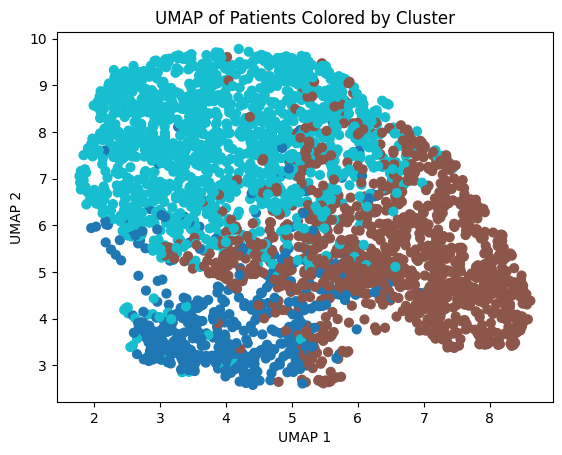

Silhouette Score: 0.1397
UMAP Calinski-Harabasz Index: 0.21
UMAP Davies-Bouldin Index:    1.96


In [8]:
# plot clustering results
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import umap
import seaborn as sns
from lifelines import KaplanMeierFitter
import pandas as pd
from sklearn.manifold import MDS

def evaluate_and_plot_clusters(dist_matrix, cluster_results, patient_ids):
    # Step 1: Map patient ID to index
    id_to_index = {pid: idx for idx, pid in enumerate(patient_ids)}

    # Step 2: Create flat cluster label array
    labels = np.zeros(len(patient_ids), dtype=int)
    for cluster_id, group in enumerate(cluster_results):
        for patient_id in group:
            idx = id_to_index[patient_id]
            labels[idx] = cluster_id

    # UMAP reduction
    umap_reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='precomputed', random_state=42)
    X_umap = umap_reducer.fit_transform(dist_matrix)

    plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='tab10', s=40)
    plt.title("UMAP of Patients Colored by Cluster")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.show()

    # Compute CHI and DBI
    ch_score_umap = calinski_harabasz_score(dist_matrix, labels)
    db_score_umap = davies_bouldin_score(dist_matrix, labels)
    silhouette = silhouette_score(dist_matrix, labels, metric='precomputed')
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"UMAP Calinski-Harabasz Index: {ch_score_umap / 3013:.2f}")
    print(f"UMAP Davies-Bouldin Index:    {db_score_umap:.2f}")

evaluate_and_plot_clusters(dist_matrix, cluster_results, patient_ids)